<a href="https://colab.research.google.com/github/yechansota/Ethics-and-Data-Privacy/blob/main/privacy_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MSBA 6141 (001/002) Ethics and Data Privacy (Fall 2023)
## Evaluate Privacy Policy

Privacy policies are encountered frequently, such as when creating an account on a website, opening a new credit card, or signing up for a grocery store loyalty program. Despite their commonness, most people have never read a privacy policy from start to finish. Even if someone were to read a privacy policy, it might be difficult to understand due to the complex, legalistic, and opaque language often used.

These observations raise ethical concerns about whether organizations are transparent enough about the vast amounts of data they collect about their users, customers, employees, and other stakeholders.

The purpose of this notebook is to help to gain a better understanding of the landscape of contemporary privacy policies, using a data-driven approach. We'll leverage a [new dataset](https://github.com/ansgarw/privacy) that provides the full text of privacy policies for hundreds of publicly-traded companies, which we'll analyze using some techniques from natural language processing.


# Roadmap
  * Preliminaries (packages + data wrangling)
  * Topic models
  * Keywords in context
  * Named entities
  * Readability
  * Embeddings
  * Exercises

# Preliminaries

Sart out by loading some packages using pandas to help with data wrangling and holding the data in an easy to work with data frame format.

The json package is part of the Python Standard Library and will help us with reading the raw data. Matplotlib is for plotting; umap is for clustering policies and is not completely necessary.

I use several natural language processing packages, spacy, textacy, and gensim, for the actual text analysis.

In [1]:
# download textacy
!pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.0 MB/s eta 0:00:00


In [2]:
# download spacy language model
!python -m spacy download en_core_web_lg

2023-10-22 03:19:11.040117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 03:19:13.063653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
# download umap
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=176c3cad60250e2f8db03522fdc9749297c5d655954d010c2262c92e9ff3e9fd
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=c1d4d0aec754c97f26320772fe4345184ded0819f219490200a7762244581eac
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for datas

In [4]:
# load some packages
import pandas as pd
import requests
import json
import spacy
import textacy
import textacy.text_stats
import gensim
import matplotlib.pyplot as plt
import umap
import umap.plot
from umap import umap_
from bokeh.plotting import show, output_notebook
import tqdm
tqdm.tqdm.pandas()

# for umap warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel("ERROR")

# load spacy nlp model
nlp = spacy.load("en_core_web_lg")
nlp.max_length = 2000000

In [5]:

response = requests.get("https://drive.google.com/uc?export=download&id=127gRvxc3WJ_m1C6J0lnFD1nwwmfQUo9o")
policies_df = pd.DataFrame({k:" ".join(v) for k,v in json.loads(response.text).items()}.items(),
                             columns=["url","policy_text"])

In [6]:
# check out the results
policies_df.head()

,url,policy_text
0,www.dsny.com,Investors Investors Home Stock Quote and Chart...
1,www.brf-global.com,BRF’s investor relations website includes forw...
2,www.belmond.com,"Between fig trees and vibrant floodplains, be ..."
3,www.pieris.com,Use of cookies on this website: This website u...
4,www.isoray.com,We respect your privacy and take Internet priv...


To make it easier to work with, we have used two columns to store the URL and the full text of the privacy policy. The original data comes in a json format where each URL is associated with a set of paragraphs that make up the privacy policy. In the code above, we have combined these paragraphs into a single text string, which will make it simpler for us to work with going forward.

The codes will be processed with spacy and a new column with the processed documents will be added to the data frame.

In [7]:
policies_df = policies_df.sample(frac=0.05) # set frac to some fraction that will run in a reasonable time on your machine

In [8]:
policies_df["policy_text_processed"] = policies_df.policy_text.progress_apply(nlp)

100%|██████████| 203/203 [01:43<00:00,  1.96it/s]


With that simple line of code, spacy has done a bunch of hard work for us, including things like tokenization, part-of-speech tagging, entity parsing, and other stuff that go well beyond our needs today.

In [9]:
policies_df.head()

,url,policy_text,policy_text_processed
3695,www.wayfair.com,Define space in the garden on the patio with t...,"(Define, space, in, the, garden, on, the, pati..."
927,www.brninc.com,"At Barnwell Industries (""Barnwell""), we respec...","(At, Barnwell, Industries, (, "", Barnwell, "", ..."
1331,www.athabascaminerals.com,A visitor to our web site is not required to r...,"(A, visitor, to, our, web, site, is, not, requ..."
1125,www.qad.com,Software and Cloud Services Terms – this docum...,"(Software, and, Cloud, Services, Terms, –, thi..."
2980,www.crescitatherapeutics.com,"Crescita Therapeutics Inc. (“Crescita”, “us” o...","(Crescita, Therapeutics, Inc., (, “, Crescita,..."


The codes have loaded all the necessary packages. We need to do a little more data wrangling to prepare for some of the analyses we have in store. However, we have already done enough to get started. Let's take a first look at the data and see how it goes.

Codes will be using a natural language processing method known as topic models to achieve this. Essentially, topics can be thought of as groups of related words on a specific subject matter from within the privacy policies. After processing the data from the privacy policies, we can make it more usable for our topic modeling library (called gensim).

In [10]:
# define a processing function
process_gensim = lambda tokens: [token.lemma_.lower() for token in tokens if not(token.is_punct or token.is_stop or token.is_space or token.is_digit)]

# apply the function
policies_df["policy_text_gensim"] = policies_df.policy_text_processed.apply(process_gensim)

In [11]:
# create a gensim dictionary
gensim_dict = gensim.corpora.dictionary.Dictionary(policies_df["policy_text_gensim"])

In [12]:
# create a gensim corpus
gensim_corpus = [gensim_dict.doc2bow(policy_text) for policy_text in policies_df["policy_text_gensim"]]

In [13]:
# fit the topic model
lda_model = gensim.models.LdaModel(gensim_corpus,
                                   id2word=gensim_dict,
                                   num_topics=10,
                                   passes=1,
                                   update_every=1)

In [14]:
# show the results
lda_model.show_topics(num_topics=-1, num_words=8)

[(0,
  '0.032*"information" + 0.013*"use" + 0.012*"lac" + 0.012*"wlc" + 0.012*"site" + 0.011*"personal" + 0.010*"party" + 0.009*"cookie"'),
 (1,
  '0.043*"information" + 0.014*"site" + 0.013*"personal" + 0.013*"use" + 0.012*"provide" + 0.012*"lac" + 0.012*"service" + 0.011*"wlc"'),
 (2,
  '0.032*"information" + 0.015*"use" + 0.012*"wlc" + 0.011*"website" + 0.011*"provide" + 0.011*"lac" + 0.010*"party" + 0.010*"personal"'),
 (3,
  '0.036*"information" + 0.019*"personal" + 0.014*"use" + 0.014*"website" + 0.013*"privacy" + 0.012*"site" + 0.012*"datum" + 0.012*"collect"'),
 (4,
  '0.024*"information" + 0.017*"lac" + 0.016*"wlc" + 0.011*"website" + 0.010*"provide" + 0.010*"use" + 0.009*"personal" + 0.008*"include"'),
 (5,
  '0.031*"information" + 0.015*"lac" + 0.013*"wlc" + 0.011*"use" + 0.009*"personal" + 0.008*"arrangement" + 0.008*"service" + 0.008*"website"'),
 (6,
  '0.043*"information" + 0.018*"website" + 0.017*"personal" + 0.015*"use" + 0.012*"privacy" + 0.011*"policy" + 0.010*"site"

Through this code, it shows how coherent a model fit is. These measures generally look at the similarity among high-scoring words in topics.

In [15]:
# get coherence
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=policies_df["policy_text_gensim"], dictionary=gensim_dict, coherence="c_v")
coherence_model_lda.get_coherence()

0.38529673492228184

# Key words in context

It is important to note that the results obtained are abstract in nature. They provide us with a general idea about interesting clusters of words, but do not reveal much about the specific usage of particular words or the details of the topics being covered.

To obtain a more detailed understanding, we can use a "keyword in context" approach where we identify particular words of interest and extract their context from the document.

For instance, the following code retrieves instances of the phrase "third party" from the policies of 20 random firms. Since no random seed is set, running the code multiple times will result in different outcomes. I have provided a few additional words in the comment on the first line that you can use to check.

In [16]:
KEYWORD = "right" # "third party" # privacy, right, duty, selling, disclose, trust, inform
NUM_FIRMS = 20
with pd.option_context("display.max_colwidth", 100, "display.min_rows", NUM_FIRMS, "display.max_rows", NUM_FIRMS):
  display(
           pd.DataFrame(policies_df.sample(n=NUM_FIRMS).apply(lambda row: list(textacy.extract.kwic.keyword_in_context(row["policy_text"],
                                                                               keyword=KEYWORD,
                                                                               window_width=35)), axis=1).explode()).head(NUM_FIRMS)
)

,0
953,"(f other countries, provide certain , right, s for natural persons who are consi)"
953,"( Reach Us. In accordance with your , right, s as a data subject, you may reques)"
953,"(in your personal data. Among other , right, s as a data subject, you may obtain)"
953,"(your personal data, subject to our , right, to continue to process your person)"
953,"(rust, or mortgage). We reserve the , right, to change this Policy in the futur)"
435,"() Privacy Rule affords members the , right, to receive a notice that describes)"
435,"(ate any contractual or other legal , right, s in or on behalf of any party.\r Al)"
2329,NaN
2588,"(r and an explanation on our users’ , right, s regarding their personal informat)"
2588,"( (iv) to establish or exercise our , right, s to defend against legal claims; ()"


# Named entities

To determine whom they are discussing, we can check the entities they mention. Spacy offers an easy way to accomplish this, although it can sometimes be imprecise. When a document is processed using Spacy, it automatically identifies several types of named entities, such as people, organizations, and places. You can find the complete list of named entities at https://spacy.io/api/annotation. In our code, we will extract both organization and person entities.

In [17]:
# extract named entities from the privacy policies
pull_entities = lambda policy_text: list(set([entity.text.lower() for entity in policy_text.ents if entity.label_ in ("ORG", "PERSON")]))
policies_df["named_entities"] = policies_df.policy_text_processed.apply(pull_entities)

In [18]:
# look at the entities
with pd.option_context("display.max_colwidth", 100, "display.min_rows", 50, "display.max_rows", 50):
  display(policies_df[["url","named_entities"]].head(50))

,url,named_entities
3695,www.wayfair.com,"[suncast corporation, wayfair, valueveil, corten, veradek screens, suncast, the corten steel, ve..."
927,www.brninc.com,"[privacy policy, barnwell, internet service provider, barnwell industries, the privacy policy]"
1331,www.athabascaminerals.com,[]
1125,www.qad.com,"[qad india private ltd., errors, privacy shield, the european union, content, support advantage ..."
2980,www.crescitatherapeutics.com,"[the personal information that crescita, personal information, personal information., policy, pe..."
1357,www.vmware.com,"[rsa, the european commission's, pivotal, service, vmware's services, dell family, vmware proper..."
791,www.campbellsoupcompany.com,"[google analytics, the campbell soup company, this children’s privacy policy, legal department, ..."
3181,www.vasco.com,"[the european union, yahoo, the european data protection directive, the toolbar service, eu, goo..."
2486,www.nv5.com,"[company, affiliates, nv5 holdings, inc., the u.s. private securities litigation reform act, the..."
2421,www.uqm.com,[uqm]


In [19]:
# pull the most frequent entities
entities = policies_df["named_entities"].explode("named_entities")
NUM_WANTED = 50
with pd.option_context("display.min_rows", 50, "display.max_rows", 50):
  display(entities.groupby(entities).size().sort_values(ascending=False).head(50))

named_entities
google analytics                                35
facebook                                        32
google                                          31
eu                                              29
the european union                              22
privacy policy                                  20
twitter                                         19
personal information                            18
services                                        18
company                                         18
the european economic area                      15
eea                                             15
information                                     13
policy                                          13
the general data protection regulation          12
personal data                                   11
service                                         11
adobe                                           10
the european commission                         10
linkedin        

# Readability
When we talk about the readability of a text, we can use different metrics to evaluate it. These metrics can measure things like the length of sentences and the number of syllables per word. The goal is to assess how easy it is to read a document. Fortunately, the textacy package can help you evaluate a range of readability metrics quickly.

To determine the readability of a text, we can use different measures such as the Flesch-Kincaid grade level and the Gunning-Fog index, both of which are grade-level measures. We can use these metrics by following the codes.

In [20]:
# compute flesch_kincaid_grade_level
policies_df["flesch_kincaid_grade_level"] = policies_df.policy_text_processed.apply(textacy.text_stats.readability.flesch_kincaid_grade_level)

In [21]:
# compute gunning_fog_index
policies_df["gunning_fog_index"] = policies_df.policy_text_processed.apply(textacy.text_stats.readability.gunning_fog_index)

In [22]:
policies_df.iloc[0]["flesch_kincaid_grade_level"]

7.356852217804342

The Flesch-Kincaid grade level of a policy is determined by this information. However, we may not have much interest in the readability of a specific policy. Using pandas, we can manipulate the data and extract different metrics for all policies and add them to the data frame.

In [23]:
# let's clean up some extreme values
policies_df.loc[(policies_df.flesch_kincaid_grade_level < 0) | (policies_df.flesch_kincaid_grade_level > 20), "flesch_kincaid_grade_level"] = None
policies_df.loc[(policies_df.gunning_fog_index < 0) | (policies_df.gunning_fog_index > 20), "gunning_fog_index"] = None

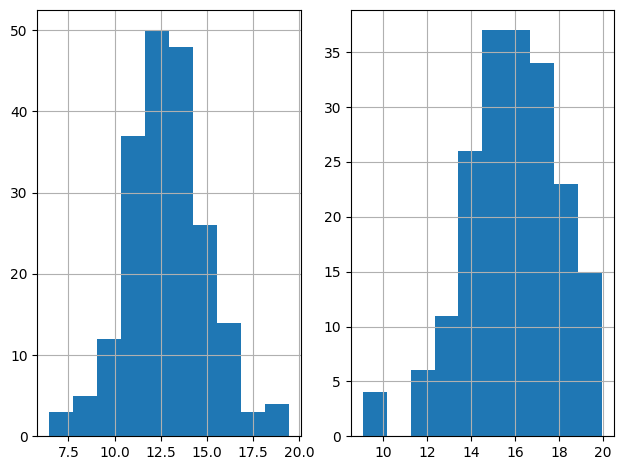

In [24]:
# plot with matplotlib
fig, axes = plt.subplots(1, 2)
policies_df["flesch_kincaid_grade_level"].hist(ax=axes[0])
policies_df["gunning_fog_index"].hist(ax=axes[1])
plt.tight_layout()

These results are pretty striking, especially when you consider them alongside statistics on the literacy rate in the United States. According to [surveys](https://www.oecd.org/skills/piaac/Country%20note%20-%20United%20States.pdf) by the OECD, about half of adults in the United States can read at an 8th grade level or lower.

# Embeddings
Comparing the similarities and differences between different policies can be insightful. For instance, it would be expected if Google's privacy policy is similar to Facebook's, but it would be surprising if Nike and Facebook have similar privacy policies.

We may wonder what kind of information they collect from us when we purchase their products. One way to compare the similarity among documents, such as privacy policies, is by embedding them in a high-dimensional vector space. Then, we can use vectorization to capture semantic relationships.

In the following section, we will obtain the document embeddings from spacy. Afterward, we will perform some dimension reduction using a technique called Uniform Manifold Approximation and Projection (UMAP) from topological data analysis. Subsequently, we will visualize the results in an interactive plot.

In [25]:
# pull the document embeddings from spacy and format for clustering
embeddings_df = policies_df[["url", "policy_text_processed"]]
embeddings_df = embeddings_df.set_index("url")
embeddings_df["policy_text_processed"] = embeddings_df["policy_text_processed"].apply(lambda text: text.vector)
embeddings_df = embeddings_df.policy_text_processed.apply(pd.Series)

/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

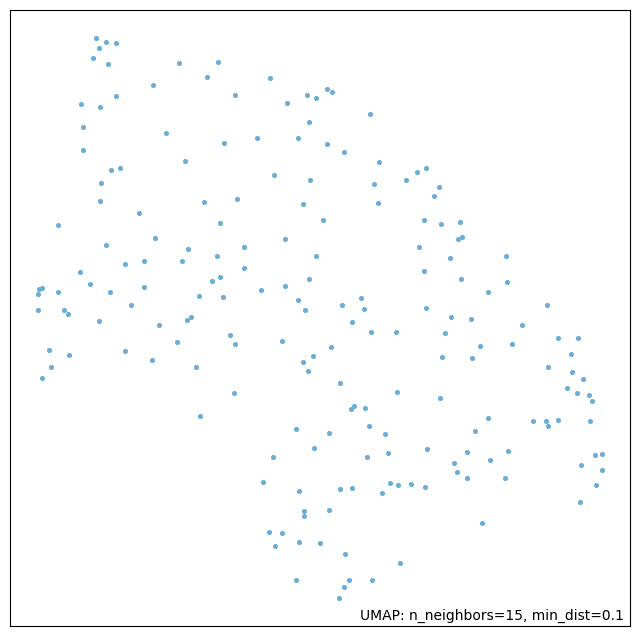

In [26]:
# non-interactive plot
# mapper = umap.UMAP().fit(embeddings_df.to_numpy())
mapper = umap.umap_.UMAP().fit(embeddings_df.to_numpy())
umap.plot.points(mapper)

# Exercises
  * After running some codes, I found myself questioning the frequency of the word "rights" used in conjunction with the word "privacy" and whether there is any evidence of considerations for fairness.

  * I've seen that the reading level for most privacy policies is quite high, but it's often a little difficult to interpret what, for example, a document written at a grade 14 reading level looks like. To gain some intuition, compute readability scores for some of your own writing (e.g., a prior course paper) and/or for some page on Wikipedia (you can use python, or do a quick Google search for an online readability calculator). How does the writing level of those compare to the privacy policies?

  * There is a general presumption that many companies use fairly standardized (or boilerplate) privacy policies that are aimed primarily at avoiding legal liability, and that do not describe their particular data practices in detail. Do we see support for these views in the data? Do the privacy policies seem more or less variable than you expected? What are the implications for customers and other stakeholders?

  * Spend some time exploring the data using any of the techniques above, or your own favorite analytical approach or tools. What additional insights can we learn about privacy policies?

During one of the sessions on Privacy in my MSBA class, I ran some code and learned about how privacy policies should be written in a way that is easily understood by everyone. After analyzing the results, I noticed that most data privacy policies are difficult to comprehend and are not accessible to a majority of people, even though they are meant to serve all generations.

It's worth noting that Professor Russell Funk provided all the codes used and we ran them together in class, sharing insights and discussing them as a group.